In [26]:
import pandas as pd
import sqlite3 as lite
import ast
import json
import re
import time
import pickle
import os

In [16]:
# langs = ['C', 'PHP','C++', 'JavaScript', 'Python', 'Ruby', 'Java', 
#  'Shell', 'Go', 'TypeScript', 'Objective-C', 'SQL', 'C#', 'Perl', 
#  'Batchfile', 'CoffeeScript', 'Scala', 'PowerShell', 'Haskell', 'Lua',
#  'Rust', 'Swift', 'R', 'Matlab', 'Erlang' ]

langs = ["PHP", "C", "JavaScript", "Python", "Java", "TypeScript", "C++", "Go", "Ruby", "Shell"]

remove_langs = ['unknown', 'Markdown', 'None', 'HTML', 'TeX', 'CSS', 'Jupyter Notebook']
remove_cwe = ['NVD-CWE-noinfo', 'NVD-CWE-Other']

cwe_top_25 = [
    "CWE-79",  # Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')
    "CWE-787",  # Out-of-bounds Write
    "CWE-89",  # Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection')
    "CWE-352",  # Cross-Site Request Forgery (CSRF)
    "CWE-22",  # Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal')
    "CWE-125",  # Out-of-bounds Read
    "CWE-78",  # Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')
    "CWE-416",  # Use After Free
    "CWE-862",  # Missing Authorization
    "CWE-434",  # Unrestricted Upload of File with Dangerous Type
    "CWE-94",  # Improper Control of Generation of Code ('Code Injection')
    "CWE-20",  # Improper Input Validation
    "CWE-77",  # Improper Neutralization of Special Elements used in a Command ('Command Injection')
    "CWE-287",  # Improper Authentication
    "CWE-269",  # Improper Privilege Management
    "CWE-502",  # Deserialization of Untrusted Data
    "CWE-200",  # Exposure of Sensitive Information to an Unauthorized Actor
    "CWE-863",  # Incorrect Authorization
    "CWE-918",  # Server-Side Request Forgery (SSRF)
    "CWE-119",  # Improper Restriction of Operations within the Bounds of a Memory Buffer
    "CWE-476",  # NULL Pointer Dereference
    "CWE-798",  # Use of Hard-coded Credentials
    "CWE-190",  # Integer Overflow or Wraparound
    "CWE-400",  # Uncontrolled Resource Consumption
    "CWE-306"   # Missing Authentication for Critical Function
]

In [17]:
def create_connection(db_file):
    """
    create a connection to sqlite3 database
    """
    conn = None
    try:
        conn = lite.connect(db_file, timeout=10)  # connection via sqlite3
    except Error as e:
        print(e)
    return conn

conn = create_connection('/home/keisuke/code/llm-code-vuln/dataset/CVEfixes_v1.0.8/Data/DB.db')

## Processing data

In [18]:
def pre_processing(df):
    # code diff: both add & del should exist
    df['diff_added'] = df.apply(lambda row: ast.literal_eval(row.diff_parsed)['added'], axis=1)
    df['diff_deleted'] = df.apply(lambda row: ast.literal_eval(row.diff_parsed)['deleted'], axis=1)
    df = df[df['diff_added'].apply(bool) & df['diff_deleted'].apply(bool)] 
    df = df.reset_index(drop=True)
    df = df.drop(columns=['diff_parsed'])

    # cve description type str -> arr
    def parse_py_literal(text):
        if not isinstance(text, str):
            return text
        try:
            return ast.literal_eval(text)
        except (SyntaxError, ValueError):
            return None
    df['cve_description'] = df['cve_description'].apply(parse_py_literal)
    
    # code before and after
    df = df[df['vuln_code'].notna()]
    df = df[df['vuln_code'] != 'None']
    df = df[df['non_vuln_code'].notna()]
    df = df[df['non_vuln_code'] != 'None']
    
    # remove rows where number of line in the code is below 30
    for col in ['vuln_code', 'non_vuln_code']:
        df[f'{col}_num_lines'] = df[col].apply(
            lambda x: x.count('\n') + 1 if isinstance(x, str) else 0
        )
        df = df[df[f'{col}_num_lines'] >= 30]

    # remove empty list in diff_deleted
    df = df[df['diff_deleted'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

    # token_count should be num
    df['token_count'] = df['token_count'].apply(parse_py_literal)
    df = df.dropna(subset=['token_count'])
    df['token_count'] = pd.to_numeric(df['token_count'])
    
    # drop the other CWE
    df = df[~df["cwe_id"].isin(remove_cwe)]
    
    df = df.dropna()
    
    return df

In [19]:
def pick_samples(df):
    sample_size = 1
    extracted_data = []

#     for token_length in [(0, 500), (500, 1000), (1000, 5000), (5000, 10000)]:
    for cwe_id in cwe_top_25:
        filtered_df = df[df['cwe_id'] == cwe_id] # HERE

        if len(filtered_df) < sample_size:
            print(f"Not enough samples for {code_type} in token range {token_length}")
            continue

        # Sample the data
        random_samples = filtered_df.sample(n=sample_size, random_state=123)

        # Add metadata for `code_type` and `token_length`
        random_samples['token_range'] = f"{token_length[0]}-{token_length[1]}"

        # Append the sampled DataFrame to the list
        extracted_data.append(random_samples)

    # Combine all sampled DataFrames into a single DataFrame
    final_extracted_df = pd.concat(extracted_data, ignore_index=True)
    return final_extracted_df

## Prompt Task

In [20]:
import ollama
from typing import Union
from pydantic import BaseModel

class Classify_template(BaseModel):
    cwe_id: str
    name: str
    description: str

class Response_template(BaseModel):
    is_this_vuln: bool
    vuln_code_part: Union[str, None]
    reason: Union[str, None]
    cwe: Union[Classify_template, None]

prompt = """
You are a security expert tasked with identifying vulnerabilities in a given code. Carefully analyze the code using CWE (Common Weakness Enumeration) descriptions step by step.

For each step:

1. Analyze the code to check if it contains any vulnerabilities.
    - If a vulnerability is identified, proceed to steps 2–4.
    - If no vulnerabilities are found, the output must be strictly: {"vulnerabilities": null}.
2. Identify the specific area in the code that could be exploited.
3. Explain why the identified area might be vulnerable, providing a detailed explanation referencing CWE descriptions.
4. Based on the analysis, identify the CWE category and include its ID, name, and description.
5. Response only the following output.

Output Requirements
The response must only contain a valid JSON object in one of the following formats:
If a vulnerability is identified:
{
    "is_this_vuln": True
    "vuln_code_part": "the code snippet that could be exploited.",
    "reason": "Detailed explanation of why the code is vulnerable.",
    "cwe": {
        "cwe_id": "CWE-XXX",
        "name": "Name of the CWE category",
        "description": "Brief description of the CWE category."
    }
}

If no vulnerabilities are found:
{
    "is_this_vuln": False
    "vuln_code_part": None,
    "reason": None,
    "cwe": None
}
"""

# models = ['llama3.1:8b', 'codellama:13b', 'phi4:latest']
models = ['phi4:latest']

def llm_classify(df):
    results_to_insert = []
    for code_type in ['vuln_code', 'non_vuln_code']:
        for s in range(len(df)):
            print(f'[Log] {code_type} sample No.{s}')
            file_change_id = None
            true_vuln = None
            version = 1
            erorr = False
            model_name = None
            result = None
            try:
                file_change_id = df.iloc[s]['file_change_id']
                true_vuln = True if code_type == 'vuln_code' else False
                actual_cwe = df.iloc[s]['cwe_id'] if code_type == 'vuln_code' else None
                error = False
                code = df.iloc[s][code_type]
                context = prompt + '\n Code: \n' + code
#                 print(context)
                # Classification
                for model in models:
                    print(f'[Log] model:{model}')
                    start_time = time.perf_counter()
                    
                    response = ollama.chat(
                        model=model, 
                        messages=[
                        {
                            'role': 'user',
                            'content': context,
                        },],
                        options={"temperature": 0},
                        format=Response_template.model_json_schema()
                    )
                    
                    end_time = time.perf_counter()
#                     print(response['message']['content'])
                    result = json.loads(response['message']['content'])
                    
                    model_name = model
                    
                    # Prepare data for insertion
                    results_to_insert.append({
                        'file_change_id': file_change_id,
                        'true_vuln': true_vuln,
                        'actual_cwe': actual_cwe,
                        'result': result,
                        'model': model_name,
                        'version': version,
                        'error': error,
                        'time': end_time - start_time
                    })
                    break # remove after test
            except Exception as e:
                    error = True
                    print(f'Something went wrong: {e}')
                    print(f'context:{context}')
                    print(f'result:{result}')
                    results_to_insert.append({
                        'file_change_id': file_change_id,
                        'true_vuln': true_vuln,
                        'actual_cwe': actual_cwe,
                        'result': result,
                        'model': model_name,
                        'version': version,
                        'error': error
                    })
            break
#         break # remove after test
    return results_to_insert

In [21]:
def purify_results(results):
    # filter CWE-num only
    for result in results:
        cwe = result['result']['cwe']
        if cwe is not None:
            cwe_string = cwe['cwe_id']
            if 'CWE-' in cwe_string:
                match = re.search('CWE-\d+', cwe_string, re.IGNORECASE)
                if match:
                    result['result']['cwe']['cwe_id'] = match.group()
                else:
                    result['result']['cwe']['cwe_id'] = None
    return results

In [78]:
%%time
    query = f"""
SELECT
    file_change.file_change_id,
    file_change.programming_language,
    cwe.cwe_id,
    cwe.cwe_name,
    file_change.code_after AS non_vuln_code,
    file_change.code_before AS vuln_code,
    cwe.description AS cwe_description,
    file_change.diff_parsed,
    cve.description AS cve_description,
    file_change.token_count
FROM file_change
    INNER JOIN fixes
        ON file_change.hash = fixes.hash
    INNER JOIN cve
        ON fixes.cve_id = cve.cve_id
    INNER JOIN cwe_classification
        ON cve.cve_id = cwe_classification.cve_id
    INNER JOIN cwe
        ON cwe_classification.cwe_id = cwe.cwe_id
WHERE
    file_change.programming_language IS NOT NULL
    AND cwe.cwe_id IS NOT NULL
    AND cwe.cwe_name IS NOT NULL
    AND file_change.code_before IS NOT NULL
    AND cwe.description IS NOT NULL
    AND file_change.diff_parsed IS NOT NULL
    AND cve.description IS NOT NULL
    AND file_change.token_count IS NOT NULL;
"""
    df = pd.read_sql(query, con=conn)
#     if len(df) <= 100: 
#         print(f'{lang} will be skipped')
#         break
    
    df = pre_processing(df)
#     df = pick_samples(df)
#     results = llm_classify(df)
#     results = purify_results(results)
#     with open(f'Baseline_{lang}.pkl', 'wb') as f:
#         pickle.dump(results, f)
#     break

CPU times: user 56.1 s, sys: 3.9 s, total: 60 s
Wall time: 1min 1s


In [23]:
df = df[df['programming_language'].isin(langs)]

## Result Analysis

In [33]:
results[0]

{'file_change_id': '53424738073065',
 'true_vuln': True,
 'actual_cwe': 'CWE-787',
 'result': {'is_this_vuln': True,
  'vuln_code_part': 'ssize_t TLSInStream::pull(gnutls_transport_ptr_t str, void* data, size_t size)',
  'reason': 'The pull function does not properly handle the case where the input stream is exhausted. If the input stream has no more data to read, it will return -1 and set errno to EAGAIN. However, this can lead to a denial of service attack if an attacker can cause the input stream to be exhausted repeatedly.',
  'cwe': {'cwe_id': 'CWE-79',
   'name': "Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')",
   'description': 'The software does not properly neutralize user-controllable input before using it in the generation of web pages. This can allow an attacker to inject malicious content into the web page, which can be executed by the client-side browser.'}},
 'model': 'llama3.1:8b',
 'version': 1,
 'error': False,
 'time': 5.1579978

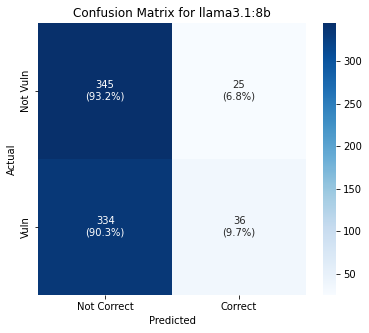

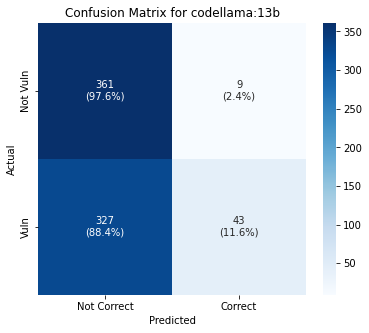

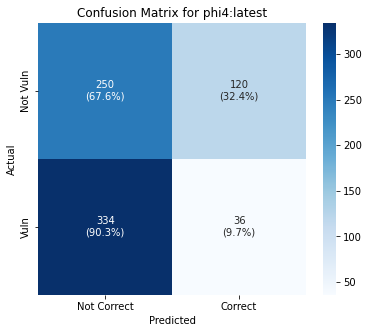

In [75]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

models = ['llama3.1:8b', 'codellama:13b', 'phi4:latest']

for model in models:
    true_labels = []
    pred_labels = []

    # Load true and predicted labels for the specific model
    for name in os.listdir('./baseline_by_lang'):
        with open(f'./baseline_by_lang/{name}', 'rb') as file:
            results = pickle.load(file)
            
            for i, result in enumerate(results):
                if result['model'] == model:  # Filter by model
                    true_labels.append(result['true_vuln'])
                    
                    # Check if 'result' and its nested elements are not None or missing
                    cwe_dict = result.get('result', {}).get('cwe')
                    is_this_vuln = result['result'].get('is_this_vuln', False)

                    if isinstance(cwe_dict, dict) and cwe_dict is not None:
                        cwe_id = cwe_dict.get('cwe_id', 'Unknown')
                    else:
                        cwe_id = 'Unknown'
                    isCorrect = (cwe_id == result['actual_cwe'])
                    
                    pred_labels.append(isCorrect if result['result']['is_this_vuln'] else (result['result']['is_this_vuln'] == result['true_vuln']))
                                       
    # Skip if no data for the model
    if not true_labels:
        print(f"No data available for model: {model}")
        continue

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    cm_percent = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True) * 100  # Convert to percentages

    # Create labels showing count and percentage
    labels = np.array([[f"{count}\n({perc:.1f}%)" if count > 0 else "0\n(0.0%)" 
                        for count, perc in zip(row_count, row_perc)] 
                       for row_count, row_perc in zip(cm, cm_percent)])

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Not Correct', 'Correct'], yticklabels=['Not Vuln', 'Vuln'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model}')
    plt.show()


In [106]:
# Define the list of languages and CWE IDs
langs = ["PHP", "C", "JavaScript", "Python", "Java", "TypeScript", "C++", "Go", "Ruby", "Shell"]
cwe_top_25 = [
    "CWE-79", "CWE-787", "CWE-89", "CWE-352", "CWE-22", "CWE-125", "CWE-78", "CWE-416",
    "CWE-862", "CWE-434", "CWE-94", "CWE-20", "CWE-77", "CWE-287", "CWE-269", "CWE-502",
    "CWE-200", "CWE-863", "CWE-918", "CWE-119", "CWE-476", "CWE-798", "CWE-190", "CWE-400", "CWE-306"
]

# Filter for only the relevant CWE IDs and programming languages
df_filtered = df[df['cwe_id'].isin(cwe_top_25) & df['programming_language'].isin(langs)]

# Count occurrences of each (cwe_id, programming_language)
df_counts = df_filtered.groupby(['cwe_id', 'programming_language']).size().reset_index(name='count')

# Filter for CWE IDs that have at least 10 samples per language
df_valid = df_counts[df_counts['count'] >= 10]

# Find CWE IDs that appear in all the languages
valid_cwes = df_valid.groupby('cwe_id')['programming_language'].nunique()
cwe_with_all_langs = valid_cwes[valid_cwes == len(langs)].index

# Get final dataset with only these CWE IDs
final_df = df_valid[df_valid['cwe_id'].isin(cwe_with_all_langs)]

In [107]:
final_df['cwe_id'].unique()

array(['CWE-20', 'CWE-200', 'CWE-22', 'CWE-400'], dtype=object)

In [108]:
final_df

,cwe_id,programming_language,count
17,CWE-20,C,643
18,CWE-20,C++,271
19,CWE-20,Java,20
20,CWE-20,JavaScript,54
21,CWE-20,PHP,219
22,CWE-20,Python,66
23,CWE-20,TypeScript,139
24,CWE-200,C,93
25,CWE-200,C++,19
26,CWE-200,Java,14


In [109]:
tmp = df[df['programming_language'].isin(langs) & ]

In [113]:
tmp['programming_language'].value_counts()

programming_language
PHP           6863
C             4935
JavaScript    1794
Java          1610
C++           1581
Python        1430
TypeScript    1212
Name: count, dtype: int64